In [27]:
#By: Anushka Chokshi, Aditi Jorapur (Group 17)

#imports
import os
import findspark
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns

#installations
!tar -xzf spark-3.4.1-bin-hadoop3.tgz
!pip install -q findspark
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz

#java and spark environment vars
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

#spark session setup
findspark.init()
spark = SparkSession.builder.appName("ColabSparkML").getOrCreate()
spark


In [28]:
#dataset read in as a df
#Please Note: You will have to download and upload (locally on colab) the studentperformaceofficial.csv from our github to run this script
df = spark.read.csv("/content/studentperformaceofficial.csv", header=True, inferSchema=True)

#show first 10 values (for basic metadata please look at github files, this script is for advanced, nontrivial info)
df.show(10)

+------+--------------+---------------------------+------------+-----------------------+----------+-------------+-------------+
|gender|race/ethnicity|parental level of education|       lunch|test preparation course|math score|reading score|writing score|
+------+--------------+---------------------------+------------+-----------------------+----------+-------------+-------------+
|female|       group B|          bachelor's degree|    standard|                   none|        72|           72|           74|
|female|       group C|               some college|    standard|              completed|        69|           90|           88|
|female|       group B|            master's degree|    standard|                   none|        90|           95|           93|
|  male|       group A|         associate's degree|free/reduced|                   none|        47|           57|           44|
|  male|       group C|               some college|    standard|                   none|        76|     

In [34]:
#Objective #1 - does test preparation, completed vs not, play a role in any of the 3 scores?

#calculate avergar of each score + overall based on completed vs not
df.groupBy("test preparation course").avg("math score", "reading score", "writing score").show()

#Answer: Yes, test prep plays a role in the averages of student scores BUT not to a great extent

+-----------------------+-----------------+------------------+------------------+
|test preparation course|  avg(math score)|avg(reading score)|avg(writing score)|
+-----------------------+-----------------+------------------+------------------+
|              completed|69.69553072625699| 73.89385474860335| 74.41899441340782|
|                   none| 64.0778816199377| 66.53426791277259| 64.50467289719626|
+-----------------------+-----------------+------------------+------------------+



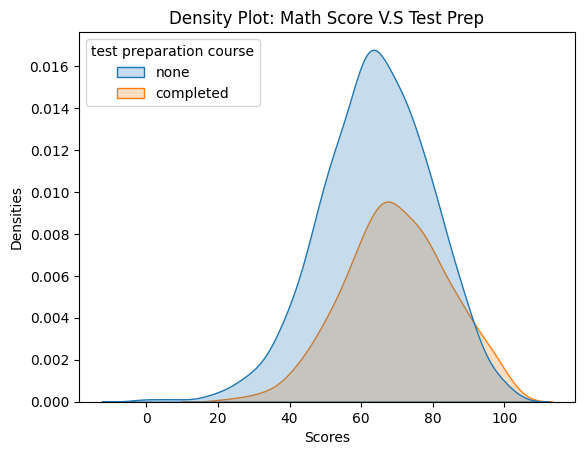

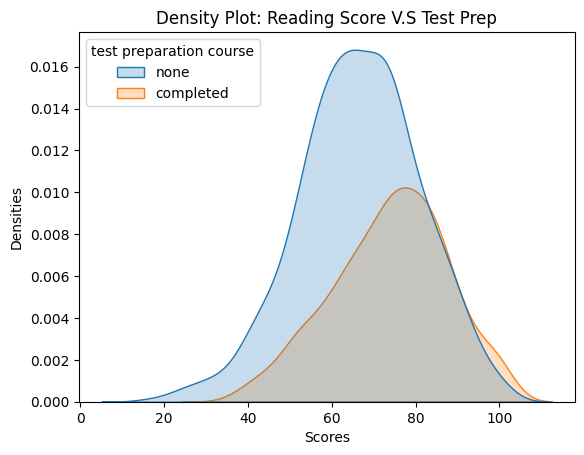

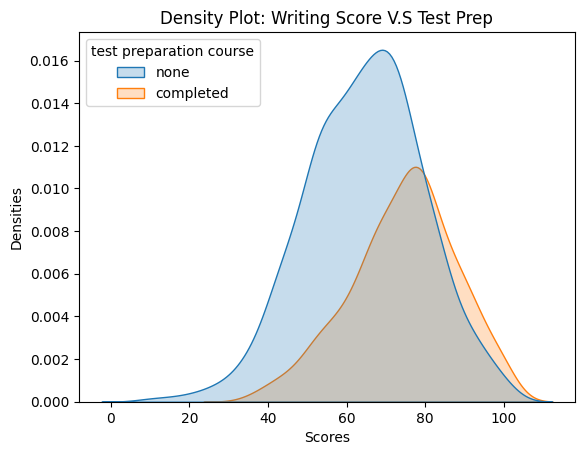

In [41]:
#Objective #1 (visuals)

#lets see a density plot - which is the easiest for this data
#convert df to pandas
pandas_df = df.toPandas()

#plot for each category (see math, reading, and writing visualz test prep vs none)
for subject in ["math score", "reading score", "writing score"]:
 sns.kdeplot(data=pandas_df, x=subject, hue="test preparation course", fill=True)
 plt.title(f"Density Plot: {subject.title()} V.S Test Prep")
 plt.xlabel("Scores")
 plt.ylabel("Densities")
 plt.show()

In [43]:
#Objective #2: does socioeconomic background (here based on parent level of education) play a role in scores?

#group by parent education level (e.g bachelor's degree) and find average of each score in descending order
df.groupBy("parental level of education").avg("math score", "reading score", "writing score").orderBy("avg(math score)", ascending=False).show()

#Answer: YES! clearly the lower the level of parental education, the lower the average respective score goes

+---------------------------+------------------+------------------+------------------+
|parental level of education|   avg(math score)|avg(reading score)|avg(writing score)|
+---------------------------+------------------+------------------+------------------+
|            master's degree|  69.7457627118644| 75.37288135593221| 75.67796610169492|
|          bachelor's degree| 69.38983050847457|              73.0| 73.38135593220339|
|         associate's degree| 67.88288288288288| 70.92792792792793|  69.8963963963964|
|               some college|  67.1283185840708| 69.46017699115045| 68.84070796460178|
|           some high school|63.497206703910614| 66.93854748603351| 64.88826815642459|
|                high school| 62.13775510204081| 64.70408163265306| 62.44897959183673|
+---------------------------+------------------+------------------+------------------+



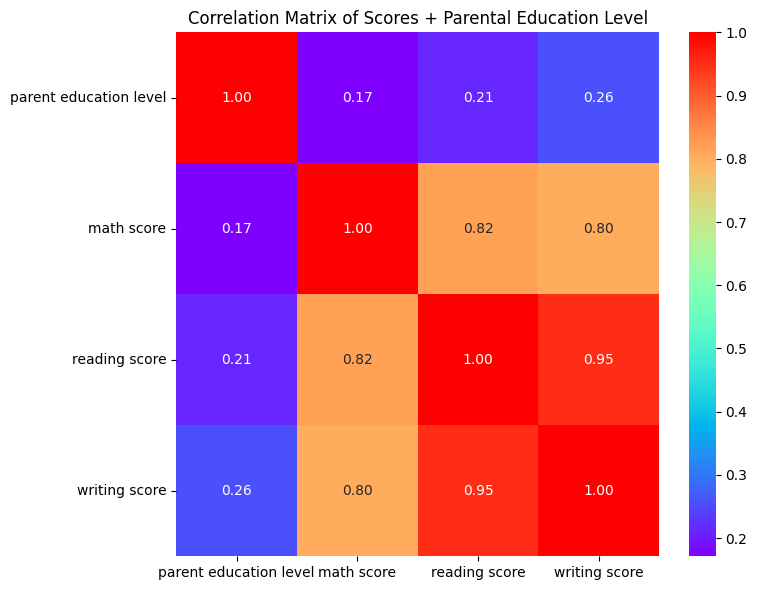

In [55]:
#Objective #2: correlation matrix visual

#map education level for matrix
education_map = {"high school": 1,"some high school": 2,"some college": 3,"associate's degree": 4,"bachelor's degree": 5,"master's degree": 6}
#make dataframe for it
pandas_df["parent education level"] = pandas_df["parental level of education"].map(education_map)

#now the dataframe for the numbers of scores
numeric_df = pandas_df[["parent education level", "math score", "reading score", "writing score"]]

# make the matrix
cor_matrix = numeric_df.corr()

# plot the matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cor_matrix, annot=True, cmap="rainbow", fmt=".2f")
plt.title("Correlation Matrix of Scores + Parental Education Level")
plt.tight_layout()
plt.show()


In [57]:
#Objective 3 - socioeconomic background but now vs lunch (free/reduced vs standard)
df.groupBy("lunch").avg("math score", "reading score", "writing score").show()

#Answer: this impacts scores clearly!

+------------+-----------------+------------------+------------------+
|       lunch|  avg(math score)|avg(reading score)|avg(writing score)|
+------------+-----------------+------------------+------------------+
|free/reduced|58.92112676056338| 64.65352112676057| 63.02253521126761|
|    standard|70.03410852713178| 71.65426356589147|  70.8232558139535|
+------------+-----------------+------------------+------------------+



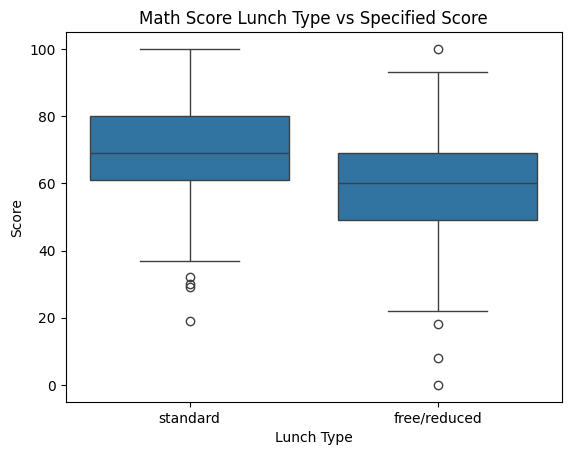

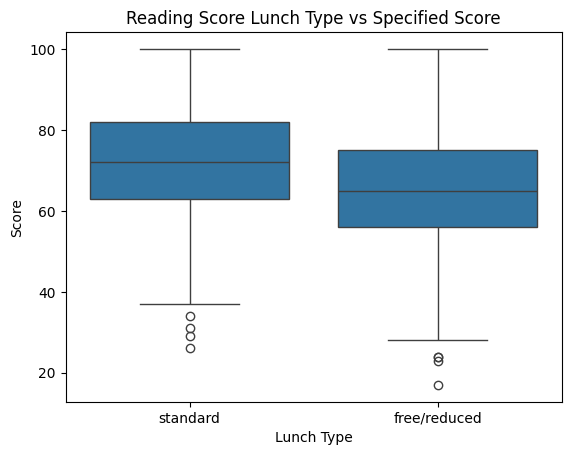

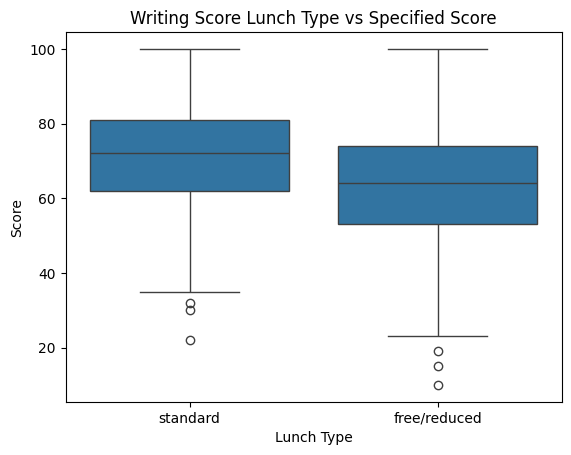

In [60]:
#Objective 3 - visual

#box plot
for subject in ["math score", "reading score", "writing score"]:
  sns.boxplot(data=pandas_df, x="lunch", y=subject)
  plt.title(f"{subject.title()} Lunch Type vs Specified Score")
  plt.xlabel("Lunch Type")
  plt.ylabel("Score")
  plt.show()